# DS-SF-36 | 11 | Regularization | Codealong | Starter Code

In [1]:
import os

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 20)
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 10)

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import preprocessing, linear_model, model_selection, metrics

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

## Part A | Closed-form solution for $\hat{\beta}$

In [2]:
df = pd.read_csv(os.path.join('..', 'datasets', 'dataset-11-zillow.csv'), index_col = 'ID')

In [3]:
df.dropna(subset = ['Size', 'SalePrice'], inplace = True)

train_X = df[ ['Size'] ]
train_X = sm.add_constant(train_X)

train_y = df.SalePrice

smf.OLS(train_y, train_X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              SalePrice   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.235
Method:                 Least Squares   F-statistic:                     297.4
Date:                Mon, 31 Jul 2017   Prob (F-statistic):           2.67e-58
Time:                        20:33:45   Log-Likelihood:                -1687.9
No. Observations:                 967   AIC:                             3380.
Df Residuals:                     965   BIC:                             3390.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.1551      0.084      1.842      0.066        -0.010     0.320
Size           0.7497      0.043     17.246      0.000         0.664     0.835
==============================================================================
Omnibus:                     1842.865   Durbin-Watson:                   1.704
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3398350.943
Skew:                          13.502   Prob(JB):                         0.00
Kurtosis:                     292.162   Cond. No.                         4.40
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [20]:
np.linalg.inv(np.dot(train_X.T, train_X)).dot(train_X.T).dot(train_y)

array([ 0.15505177,  0.74972809])

In [7]:
foo = np.dot(train_X.T, train_X)

In [11]:
bar = np.linalg.inv(foo)

In [12]:
np.dot(foo, bar)

array([[ 1.,  0.],
       [ 0.,  1.]])

## Part B | Regularization

### Truth

In [21]:
def f(x):
    return np.sin(2 * np.pi * x)

In [22]:
truth_df = pd.DataFrame(index = range(100))
truth_df['x'] = np.linspace(0, 1, truth_df.shape[0])
truth_df['y'] = truth_df.x.apply(f)

### Training/testing sets

- (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

In [23]:
np.random.seed(0)

df = pd.DataFrame(index = range(100))
df['x'] = np.random.uniform(0, 1, size = df.shape[0])

df['Noise'] = np.random.normal(size = df.shape[0])
df['y'] = df.x.apply(f) * (1 + .5 * df.Noise)

In [24]:
X = df[ ['x'] ]
y = df.y

In [25]:
train_X, test_X, train_y, test_y = model_selection.train_test_split(X, y, train_size = .25)

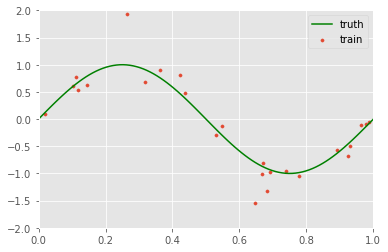

In [26]:
plt.figure()
plt.xlim((truth_df.x.min(), truth_df.x.max()))
plt.ylim((-2, 2))

plt.plot(truth_df.x, truth_df.y, color = 'green', label = 'truth')
plt.scatter(train_X.x, train_y, s = 10, label = 'train')

plt.legend()

### Polynomial Models

- (http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html)
- (http://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html)

In [29]:
class Polynomial(object):
    def __init__(self, n):
        self.features = preprocessing.PolynomialFeatures(n)
        self.model = linear_model.LinearRegression()

    def fit(self, X, y):
        self.X = X
        
        self.features.fit(X)
        
        X = self.features.transform(X)
        
        self.model.fit(X, y)

        return self

    def predict(self, X):
        X = self.features.transform(X)
        return self.model.predict(X)
        # TODO

    def score(self, X, y):
        X = self.features.transform(X)
        return np.log(2 - self.model.score(X, y))

    def mean_squared_error(self, X, y):
        y_hat = self.predict(X)
        return np.log(metrics.mean_squared_error(y_hat, y))

In [30]:
ns = [0, 1, 2, 3, 5, 7, 9, 11, 13, 17]

models = [Polynomial(n).fit(train_X, train_y) for n in ns]

### Plots

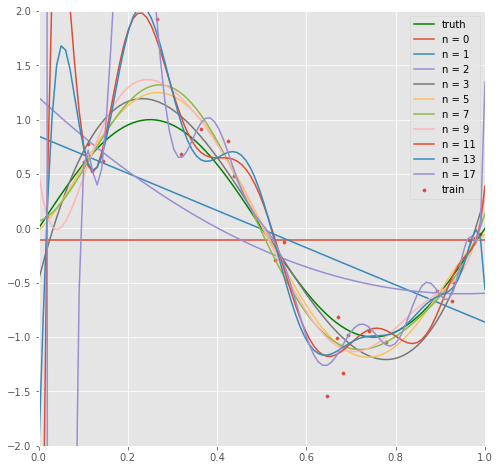

In [31]:
plt.figure(figsize = (8, 8))
plt.xlim((truth_df.x.min(), truth_df.x.max()))
plt.ylim((-2, 2))

plt.plot(truth_df.x, truth_df.y, color = 'green', label = 'truth')
plt.scatter(train_X.x, train_y, s = 10, label = 'train')

for i, n in enumerate(ns):
    X = truth_df[ ['x'] ]
    y_hat = models[i].predict(X)
    plt.plot(X.x, y_hat, label = 'n = {}'.format(n))

plt.legend()

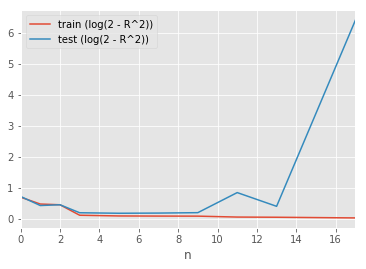

In [32]:
score_df = pd.DataFrame({'n': ns, 'model': models})
score_df['train (log(2 - R^2))'] = score_df.model.apply(lambda model: model.score(train_X, train_y))
score_df['test (log(2 - R^2))'] = score_df.model.apply(lambda model: model.score(test_X, test_y))

score_df.drop('model', axis = 1).set_index('n').plot()

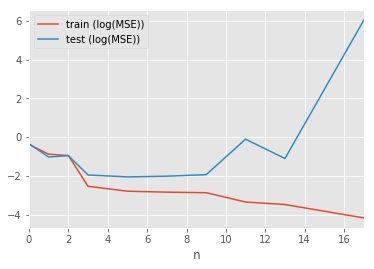

In [33]:
mean_squared_error_df = pd.DataFrame({'n': ns, 'model': models})

mean_squared_error_df['train (log(MSE))'] = mean_squared_error_df.model.\
    apply(lambda model: model.mean_squared_error(train_X, train_y))

mean_squared_error_df['test (log(MSE))'] = mean_squared_error_df.model.\
    apply(lambda model: model.mean_squared_error(test_X, test_y))

mean_squared_error_df.drop('model', axis = 1).set_index('n').plot()

### Regularization

- (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)
- (http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)

#### Ridge

In [34]:
class RidgePolynomial(object):
    def __init__(self, alpha, n):
        self.features = preprocessing.PolynomialFeatures(n)
        self.model = linear_model.Ridge(alpha)

    def fit(self, X, y):
        self.X = X
        self.features.fit(X)

        X = self.features.transform(X)
        self.model.fit(X, y)

        return self

    def predict(self, X):
        X = self.features.transform(X)
        return self.model.predict(X)

    def score(self, X, y):
        X = self.features.transform(X)
        return self.model.score(X, y)

    def mean_squared_error(self, X, y):
        y_hat = self.predict(X)
        return metrics.mean_squared_error(y_hat, y)

    def complexity(self):
        return np.sqrt(np.sum((self.model.coef_) ** 2))

In [35]:
alphas = [1e-1, 1e-2, 1e-3, 1e-5, 1e-7, 1e-9, 1e-11]

models = [RidgePolynomial(alpha, 17).fit(train_X, train_y) for alpha in alphas]

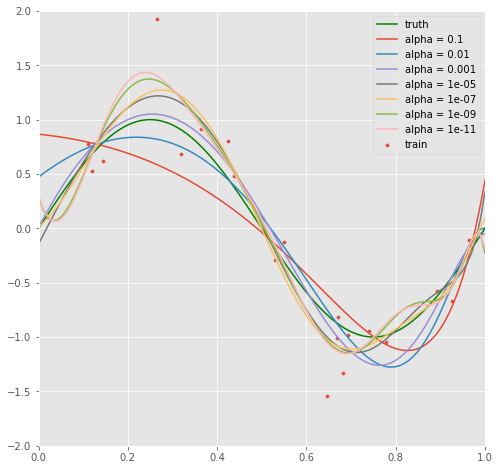

In [36]:
plt.figure(figsize = (8, 8))
plt.xlim((truth_df.x.min(), truth_df.x.max()))
plt.ylim((-2, 2))

plt.plot(truth_df.x, truth_df.y, color = 'green', label = 'truth')
plt.scatter(train_X.x, train_y, s = 10, label = 'train')

for i, alpha in enumerate(alphas):
    X = truth_df[ ['x'] ]
    y_hat = models[i].predict(X)
    plt.plot(X.x, y_hat, label = 'alpha = {}'.format(alpha))

plt.legend()

In [37]:
model_df = pd.DataFrame({'alpha': alphas, 'model': models})
model_df['R^2 (train)'] = model_df.model.apply(lambda model: model.score(train_X, train_y))
model_df['R^2 (test)'] = model_df.model.apply(lambda model: model.score(test_X, test_y))
model_df['Complexity'] = model_df.model.apply(lambda model: model.complexity())

model_df.drop('model', axis = 1).set_index('alpha')

,R^2 (train),R^2 (test),Complexity
alpha,,,
1.000000e-01,0.713584,0.652202,3.009789
1.000000e-02,0.838112,0.755380,9.428890
1.000000e-03,0.891422,0.806807,19.870429
1.000000e-05,0.912538,0.816135,61.715585
1.000000e-07,0.915987,0.809221,254.213187
1.000000e-09,0.922128,0.793676,4659.913280
1.000000e-11,0.924141,0.784461,36093.413635


In [38]:
models[4].model.coef_

array([   0.        ,    3.45452467,   32.31642375, -127.70433788,
         84.36833054,   26.9782999 ,   -9.99344388,   17.37942265,
         31.52408556,    2.18081594,  -44.63234668,  -69.81497688,
        -52.29302962,    2.06926011,   65.27957176,   96.71979491,
         52.1333667 , -109.88326208])

#### Lasso

In [39]:
class LassoPolynomial(object):
    def __init__(self, alpha, n):
        self.features = preprocessing.PolynomialFeatures(n)
        self.model = linear_model.Lasso(alpha)

    def fit(self, X, y):
        self.X = X
        self.features.fit(X)

        X = self.features.transform(X)
        self.model.fit(X, y)

        return self

    def predict(self, X):
        X = self.features.transform(X)
        return self.model.predict(X)

    def score(self, X, y):
        X = self.features.transform(X)
        return self.model.score(X, y)

    def mean_squared_error(self, X, y):
        y_hat = self.predict(X)
        return metrics.mean_squared_error(y_hat, y)

    def complexity(self):
        return np.sum(np.abs(self.model.coef_))

In [40]:
alphas = [1e-1, 1e-2, 1e-3, 1e-5, 1e-7, 1e-9, 1e-11]

models = [LassoPolynomial(alpha, 17).fit(train_X, train_y) for alpha in alphas]

/Users/ivan/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


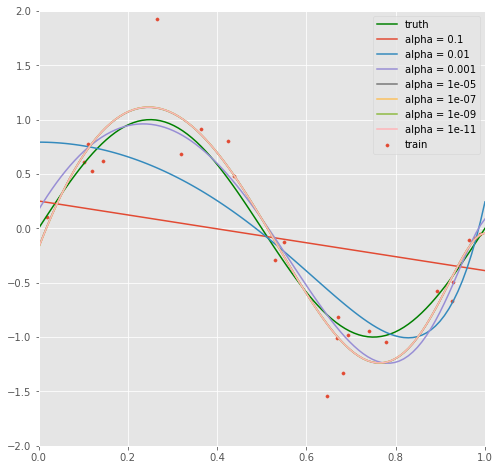

In [41]:
plt.figure(figsize = (8, 8))
plt.xlim((truth_df.x.min(), truth_df.x.max()))
plt.ylim((-2, 2))

plt.plot(truth_df.x, truth_df.y, color = 'green', label = 'truth')
plt.scatter(train_X.x, train_y, s = 10, label = 'train')

for i, alpha in enumerate(alphas):
    X = truth_df[ ['x'] ]
    y_hat = models[i].predict(X)
    plt.plot(X.x, y_hat, label = 'alpha = {}'.format(alpha))

plt.legend()

In [42]:
model_df = pd.DataFrame({'alpha': alphas, 'model': models})
model_df['R^2 (train)'] = model_df.model.apply(lambda model: model.score(train_X, train_y))
model_df['R^2 (test)'] = model_df.model.apply(lambda model: model.score(test_X, test_y))
model_df['Complexity'] = model_df.model.apply(lambda model: model.complexity())

model_df.drop('model', axis = 1).set_index('alpha')

,R^2 (train),R^2 (test),Complexity
alpha,,,
1.000000e-01,0.241983,0.237192,0.640214
1.000000e-02,0.701186,0.651788,6.188723
1.000000e-03,0.870524,0.790604,32.465307
1.000000e-05,0.895161,0.807674,52.645937
1.000000e-07,0.895343,0.807812,53.052375
1.000000e-09,0.895345,0.807814,53.056405
1.000000e-11,0.895345,0.807814,53.056445


In [43]:
models[-1].model.coef_

array([  0.        ,  10.74187492, -22.72776733,   0.137857  ,
         5.48304531,   4.93374986,   3.17555785,   1.61040409,
         0.51386873,  -0.15911981,  -0.51759782,  -0.66237011,
        -0.67090868,  -0.59844541,  -0.48267566,  -0.34843419,
        -0.21147347,  -0.0812949 ])